# Predicting Customer's Age from Photo

# Content

* [Introduction](#introduction)
* [Initialization](#initialization)
* [Data Exploration](#data_exploration)
	* [Conclusion](#conclusion)
* [Exploratory Data Analysis (EDA)](#eda)
	* [Conclusion](#conclusion)
* [Modeling](#model)
* [Script to Run on the GPU Platform](#script)
	* [Output](#output)
* [Conclusion](#conclusion)


## Introduction 

The supermarket chain, Good Seed, wants to explore whether they data science can help them adhere to alcohol laws by making sure that they do not sell alcohol to minors. To conduct the evaluation, we must keep the following in mind:

* The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol

* Computer vision methods can be used to determine age of a person from a photo

* The task is to build and evaluate a model for verifying people's age

**Data Description:**

* `final_files` folder has 7.6k photos
* `labels.csv` has a file with two columns:
    * `file_name`
    * `real_age`
    
**Objectives:**

* Train and evaluate a model to verify people's age
* Obtain a mean absolute error (MAE) score that is less than 8.0 for the validation set


## Initialization

In [51]:
# Loading all libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
# Loading the data
labels = pd.read_csv('/datasets/faces/labels.csv')

## Data Exploration

Desription of data:

The dataset is stored in the `/datasets/faces/` folder, there we can find
- The `final_files` folder with 7.6k photos

- The `labels.csv` file with labels, with two columns: 
    * `file_name`
    * `real_age`

In [3]:
# Obtaining first five rows of the table
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
# Obtaining the number of rows and columns
shape = labels.shape
print('The table has {} rows and {} columns'.format(shape[0], shape[1]))

The table has 7591 rows and 2 columns


In [5]:
# Obtaining general information 
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Since each column has 7,591 rows, there are no missing values in this dataframe. 

In [8]:
# Obtaining statistical summary of table
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
# Checking for duplicates
labels.duplicated().sum()

0

In [7]:
# Data generator
datagen = ImageDataGenerator(rescale=1/255)

# Extracting data from folder
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


### Conclusion 

Our dataset contains 7,591 rows and 2 columns. Since each column contains 7,591 rows, there are no missing data in the table. Our dataframe also contains no duplicates. All column names follow good rules of style. From the statistical description of the dta, we can see that the average age is 31 years old. 

Now we will carry out exploratory data analysis to perform initial investigations on the data so as to discover patterns and spot anomalies before training.

## Exploratory Data Analysis (EDA)

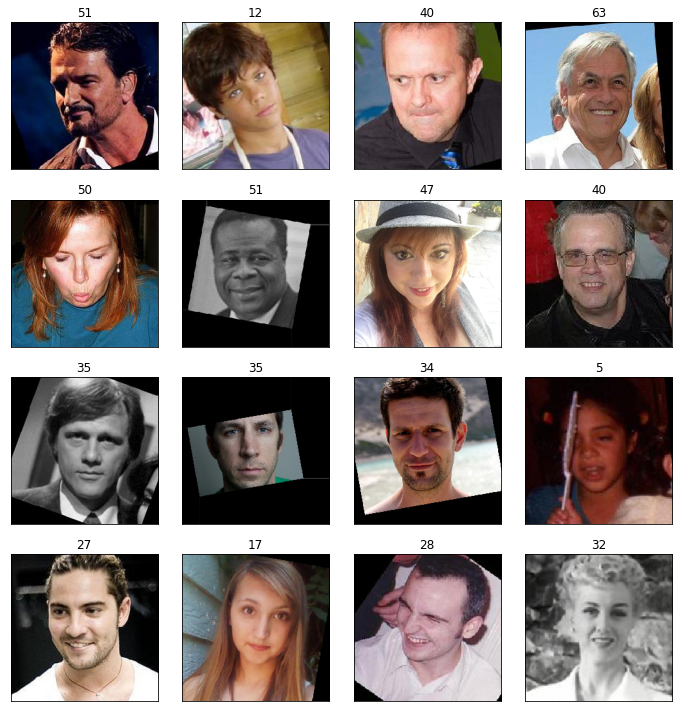

In [10]:
# Displaying 16 images
features, target = next(datagen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    
    # Removing axes and placing images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<Figure size 1008x720 with 0 Axes>

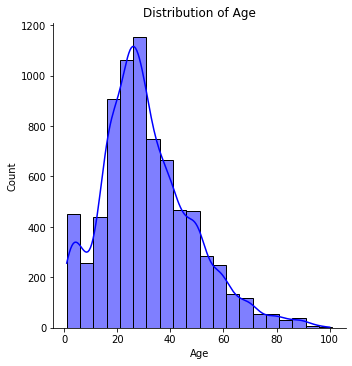

In [37]:
# PLotting distribution of age
plt.figure(figsize=(14, 10))
sns.displot(labels, x='real_age', bins=20, binwidth=5, kde=True, color='blue')
plt.title('Distribution of Age')
plt.ylabel('Count')
plt.xlabel('Age')
plt.show()

Text(0.5, 0, 'Age')

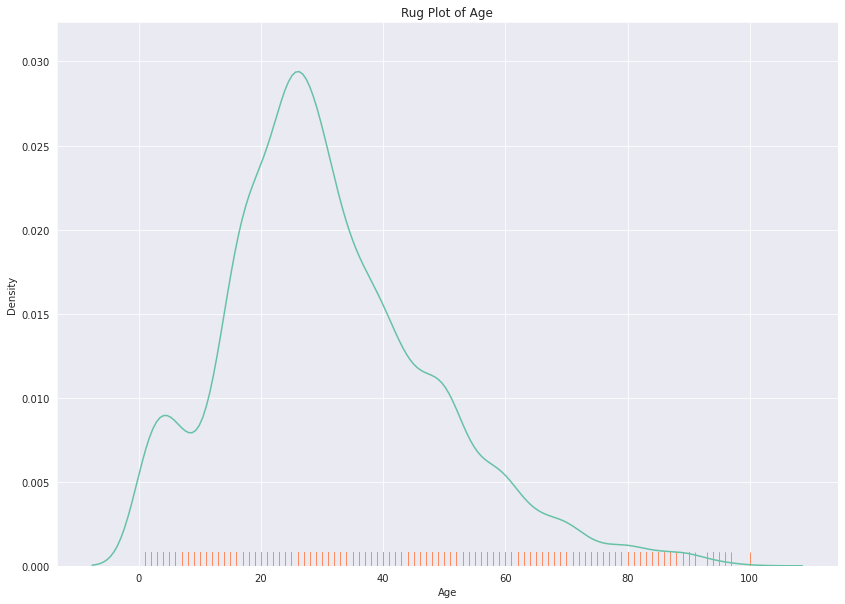

In [49]:
# Rugplot of age
plt.figure(figsize=(14, 10))
sns.kdeplot(data=labels, x="real_age")
sns.rugplot(x = labels['real_age'])
plt.title('Rug Plot of Age')
plt.ylabel('Density')
plt.xlabel('Age')

Text(0.5, 0, 'Age')

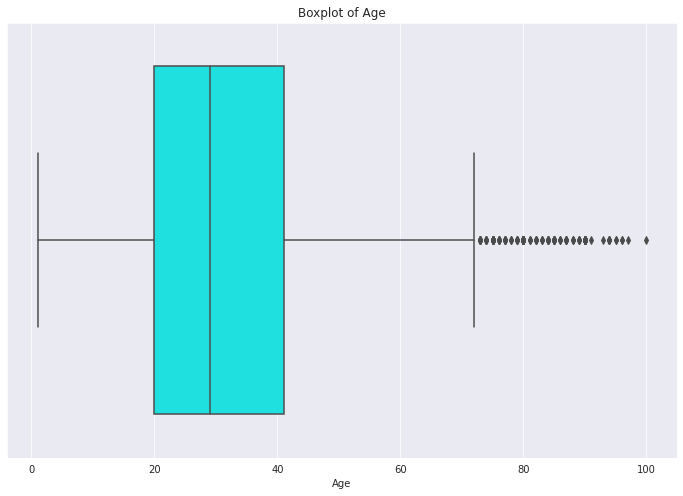

In [46]:
#Boxplot of age
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')
sns.boxplot(x=labels['real_age'], color='cyan')
plt.title('Boxplot of Age')
plt.xlabel('Age')

### Conclusion 

We plotted the distribution of age in three different ways. From our plot, we observed that the average age of customers is 30 years old. We see that people aged 16-40 visted Good Seed the most often. From our rugplot and histogram, we see that a good amount of children also visit the store, which can be attributed to parents bringing their kids with them to the store. The boxplot of age showed that those in their 70s and up were the outliers. 

## Modeling

In [57]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path+'labels.csv')                                                     
    
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25, horizontal_flip=True, vertical_flip=True)  
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

In [58]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path+'labels.csv')  
    
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)  
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation', 
        seed=12345)

    return test_datagen_flow

In [54]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet', 
                    include_top= False)
    
    model = Sequential()
    
    model.add(backbone)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(lr=0.0001)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 

    return model

In [55]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data, 
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## Script to Run on the GPU Platform

In [61]:
# Preparing a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Train for 178 steps, validate for 60 steps

Epoch 1/10
2022-05-13 00:34:43.116895: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-13 00:34:43.711403: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 85s - loss: 251.2191 - mae: 11.5438 - val_loss: 798.7862 - val_mae: 23.3504

Epoch 2/10
178/178 - 37s - loss: 103.1002 - mae: 7.6882 - val_loss: 673.7310 - val_mae: 20.7109

Epoch 3/10
178/178 - 37s - loss: 77.4287 - mae: 6.6845 - val_loss: 284.6693 - val_mae: 12.6004

Epoch 4/10
178/178 - 37s - loss: 64.1798 - mae: 6.0935 - val_loss: 117.1645 - val_mae: 8.3754

Epoch 5/10
178/178 - 37s - loss: 53.4835 - mae: 5.5636 - val_loss: 86.7121 - val_mae: 6.9606

Epoch 6/10
178/178 - 37s - loss: 45.1322 - mae: 5.0994 - val_loss: 120.6376 - val_mae: 8.6345

Epoch 7/10
178/178 - 37s - loss: 38.5619 - mae: 4.7035 - val_loss: 79.4523 - val_mae: 6.8135

Epoch 8/10
178/178 - 37s - loss: 35.1616 - mae: 4.4665 - val_loss: 95.5715 - val_mae: 7.3566

Epoch 9/10
178/178 - 37s - loss: 29.4911 - mae: 4.1228 - val_loss: 74.7183 - val_mae: 6.5542

Epoch 10/10
178/178 - 37s - loss: 26.5164 - mae: 3.9170 - val_loss: 78.1064 - val_mae: 6.4943

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']

60/60 - 9s - loss: 78.1064 - mae: 6.4943

Test MAE: 6.4943



## Conclusion

From our plot of age, we observed that the average of customers was 30 years old. From our histogram, we saw that people aged 16 to 40 visited the store the most. We also observed that there was a significant amount of children that visited the store. This can be attributed to parents bringing their kids with them to the store. The boxplot of age showed that those in their 70s and up were outliers. 

We performed augmentations on the training set (train_datagen) by using these operations:
•	Vertical reflections
•	Horizontal reflections

We created a generator for the validation set (valid_datagen) and created a model using the ResNet50 architecture from TensorFlow. We trained the model and ran the script on the GPU platform. The mean absolute error (MAE) for our validation set was 6.49. 
